# Question 2

Is there some (temporal) relation between the commenting activity and the decision to start "depending on" a package? For example, if you are a developer of some package, and you would like to start depending on another package, you might first start to be involved through comments in that package, before you actually make the decision to depend on it. Such a possible relation could probably be checked using the statistical technique of "survival analysis".

In [2]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import collections
import itertools
import numpy as np
import warnings
import subprocess
import requests
import lifelines


import sys
sys.path.append('..')

from helper import load_data , load_repo ,read_comments , GIT_API
warnings.filterwarnings('ignore')

%matplotlib inline

palet = seaborn.color_palette('hls', 8)[0:6]

#### Read all comments and select commented from contributors and collaborators and owners

In [3]:
all_comments = read_comments();
all_comments = all_comments[lambda x: x['author_assoc'] != 'NONE'][lambda x: x['author_assoc'] != 'MEMBER']
all_comments['created_at'] = pandas.to_datetime(all_comments['created_at'])

In [4]:
all_comments.head()

,Name,user_login,author_assoc,created_at,type
1,itertools,bluss,OWNER,2017-09-05 21:42:56,cmt
2,itertools,DanielKeep,CONTRIBUTOR,2015-06-06 03:52:21,cmt
3,itertools,bluss,OWNER,2015-06-06 07:33:39,cmt
4,itertools,bluss,OWNER,2015-06-06 07:34:31,cmt
5,itertools,DanielKeep,CONTRIBUTOR,2015-06-06 07:43:55,cmt


#### Read Package dependencies with lifespan and elimination status

In [5]:
df_pckdpnd = pandas.read_csv('../data/package_dependencies_time.csv.gz',compression='gzip',parse_dates=['fst_release','lst_release','first_time','last_time'])
df_pckdpnd = df_pckdpnd.drop(df_pckdpnd.columns[0],axis=1)
df_pckdpnd.shape

(48597, 10)

48597 package dependency

#### Find contributors commented on a package before depending on it

In [51]:
cntb_cmnts = pandas.DataFrame()
new_data = pandas.DataFrame()
def check_comments(row):
    global cntb_cmnts
    global new_data
    contributors = all_comments[lambda x: x['Name'] == row['package']].user_login.unique()
    cont_depends = all_comments[lambda x: x['Name'] == row['target']][all_comments['user_login'].isin(contributors)][all_comments['created_at'] < row['first_time']]
    cntb_cmnts = cntb_cmnts.append(cont_depends.reset_index(),ignore_index=True)
    counter = collections.Counter(cont_depends.type.values)
    new_data = new_data.append({
                        "Name": row['package'],
                        "target": row['target'],
                        "contributor_commented_before_use": cont_depends.user_login.unique() if len(cont_depends)>0 else np.nan,
                        "Number_of_contributors": len(cont_depends.user_login.unique()),
                        "pulls": counter['pul'] if 'pul' in counter else 0,
                        "issues": counter['isu'] if 'isu' in counter else 0,
                        "commit": counter['cmt'] if 'cmt' in counter else 0,
                        "pullrq": counter['prq'] if 'prq' in counter else 0,
                        "comments_id": cont_depends.index.unique() if len(cont_depends)>0 else np.nan},ignore_index=True)
    return 1;
    

In [ ]:
df_pckdpnd['done'] = df_pckdpnd.apply(lambda row: check_comments(row),axis=1)

In [58]:
df_data = df_pckdpnd.drop('done',axis=1).merge(new_data,left_on=['package','target'],right_on=['Name','target'])

In [86]:
df_data.drop('Name',axis=1).to_csv('../data/all_pkgdpn_cmnted_before_depend.csv.gz',compression='gzip')
df_data.head()

,package,version,target,fst_release,lst_release,first_time,last_time,elimination,period,removed,Name,Number_of_contributors,comments_id,commit,contributor_commented_before_use,issues,pullrq,pulls,time_to_come,cntrcmnted
0,BrewStillery,1.0.0,gtk,2017-10-05 21:12:40,2018-03-05 00:56:07,2017-10-05 21:12:40,2018-03-05 00:56:07,0.000000,150.155174,0,BrewStillery,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.000000,0
1,BrewStillery,1.0.0,regex,2017-10-05 21:12:40,2018-03-05 00:56:07,2017-10-05 21:12:40,2017-10-06 15:27:04,149.395174,0.760000,1,BrewStillery,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.000000,0
2,BrewStillery,5.0.0,gio,2017-10-05 21:12:40,2018-03-05 00:56:07,2018-01-11 02:18:35,2018-03-05 00:56:07,0.000000,52.942731,0,BrewStillery,0.0,NaN,0.0,NaN,0.0,0.0,0.0,97.212442,0
3,BrewStillery,5.0.0,gdk,2017-10-05 21:12:40,2018-03-05 00:56:07,2018-01-11 02:18:35,2018-03-05 00:56:07,0.000000,52.942731,0,BrewStillery,0.0,NaN,0.0,NaN,0.0,0.0,0.0,97.212442,0
4,ConExpression,0.1.0,rand,2017-07-20 07:48:55,2017-07-20 07:48:55,2017-07-20 07:48:55,2017-07-20 07:48:55,0.000000,0.000000,0,ConExpression,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.000000,0


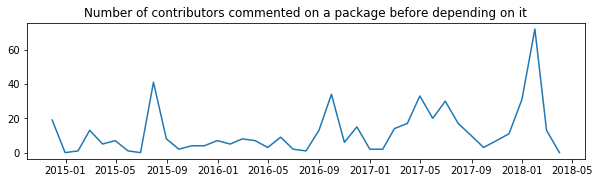

In [61]:
plt.rcParams["figure.figsize"] = (10,2.5)
fig, ax = plt.subplots()
ax.plot(df_data.groupby(pandas.Grouper(key='first_time',freq='1M'))['Number_of_contributors'].sum())
ax.set_title('Number of contributors commented on a package before depending on it')
plt.show()

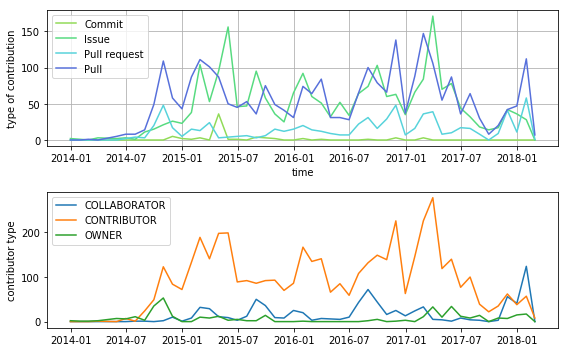

In [63]:

df_cntb_cmnt_plot = (
    cntb_cmnts[['created_at','author_assoc','type']]
    .assign(count=1)
    .groupby([pandas.Grouper(key='created_at',freq='1M'),'type'])
    .sum()
    .unstack('type')
    .fillna(0).rename(columns={'cmt': 'Commit',
                               'pul': 'Pull',
                               'isu': 'Issue',
                               'prq': 'Pull request'})
)

df_cntb_cmnt_plot2 = (
    cntb_cmnts[['created_at','author_assoc','type']]
    .assign(count=1)
    .groupby([pandas.Grouper(key='created_at',freq='1M'),'author_assoc'])
    .sum()
    .unstack('author_assoc')
    .fillna(0)
)

# one of {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}

plt.rcParams["figure.figsize"] = (8,5)
fig, axs = plt.subplots(2, 1)

df_cntb_cmnt_plot = df_cntb_cmnt_plot.xs('count', axis=1, drop_level=True).reset_index()
for i in range(1,len(df_cntb_cmnt_plot.columns)):
    axs[0].plot(df_cntb_cmnt_plot['created_at'],df_cntb_cmnt_plot[df_cntb_cmnt_plot.columns[i]],color= palet[i+1])
axs[0].set_xlabel('time')
axs[0].set_ylabel('type of contribution')
axs[0].grid(True)
axs[0].legend(('Commit','Issue','Pull request','Pull'))

axs[1].plot(df_cntb_cmnt_plot2)
axs[1].set_ylabel('contributor type')
axs[1].legend(('COLLABORATOR','CONTRIBUTOR','OWNER'))

fig.tight_layout()
plt.show()

In [69]:
cntb_cmnts = cntb_cmnts.reset_index().drop('level_0',axis=1)
cntb_cmnts.head()

,index,Name,user_login,author_assoc,created_at,type
0,3328,mio,guanqun,CONTRIBUTOR,2017-08-02 01:39:37,isu
1,4918,mio,guanqun,CONTRIBUTOR,2017-06-27 23:46:28,pul
2,4919,mio,guanqun,CONTRIBUTOR,2017-07-01 15:39:13,pul
3,4921,mio,guanqun,CONTRIBUTOR,2017-07-02 02:09:20,pul
4,4923,mio,guanqun,CONTRIBUTOR,2017-07-26 09:03:52,pul


In [72]:
def find_depend_data(index):
    index_of_cmnt = -1
    for id, row in df_data.dropna().iterrows():
        if index in row['comments_id']:
            index_of_cmnt = id
            break
    return df_data.loc[id]['first_time'] 
    
cntb_cmnts['time_of_package'] = cntb_cmnts.apply(lambda r: find_depend_data(r['index']),axis=1)

In [73]:
cntb_cmnts['time_diff'] = cntb_cmnts.apply(lambda r: (r['time_of_package']- r['created_at']).total_seconds()/3600/24,axis=1)
cntb_cmnts['year'] = cntb_cmnts.apply(lambda r: r['created_at'].year,axis=1)

In [74]:
cntb_cmnts_sorted = cntb_cmnts.sort_values('year')
cntb_cmnts_sorted.head()

,index,Name,user_login,author_assoc,created_at,type,time_of_package,time_diff,year
1672,28419,openssl,sfackler,OWNER,2013-12-30 00:36:29,isu,2014-11-22 04:05:30,327.145150,2013
1671,28417,openssl,sfackler,OWNER,2013-12-30 23:12:56,isu,2014-11-22 04:05:30,326.203171,2013
1761,30567,openssl,sfackler,OWNER,2014-10-28 02:54:45,prq,2014-11-22 04:05:30,25.049132,2014
426,29625,openssl,vhbit,CONTRIBUTOR,2014-10-09 07:40:50,pul,2016-09-29 18:26:29,721.448368,2014
427,29627,openssl,vhbit,CONTRIBUTOR,2014-10-09 08:00:44,pul,2016-09-29 18:26:29,721.434549,2014


[Text(0.5, 0, 'Time difference between start commenting on a package and start using it')]

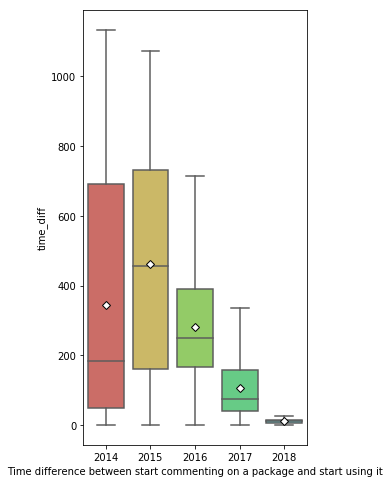

In [75]:
plt.rcParams["figure.figsize"] = (4,8)
fig, ax = plt.subplots()

seaborn.boxplot(
    x='year', 
    y='time_diff', 
    data=(
        cntb_cmnts_sorted[['year','time_diff']]
    ),
    order=range(2014, 2019),
    palette=palet,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='Time difference between start commenting on a package and start using it', 
)

In [82]:
df_data['time_to_come'] = df_data.apply(lambda x: (x['first_time'] - x['fst_release']).total_seconds()/3600/24 ,axis=1)
df_data['cntrcmnted'] = df_data.apply(lambda x: 1 if x['Number_of_contributors']>0 else 0,axis=1)

plt.rcParams["figure.figsize"] = (10,10)
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(df_data['period'], event_observed=df_data['time_to_come'])

<lifelines.KaplanMeierFitter: fitted with 48597 observations, 37293 censored>

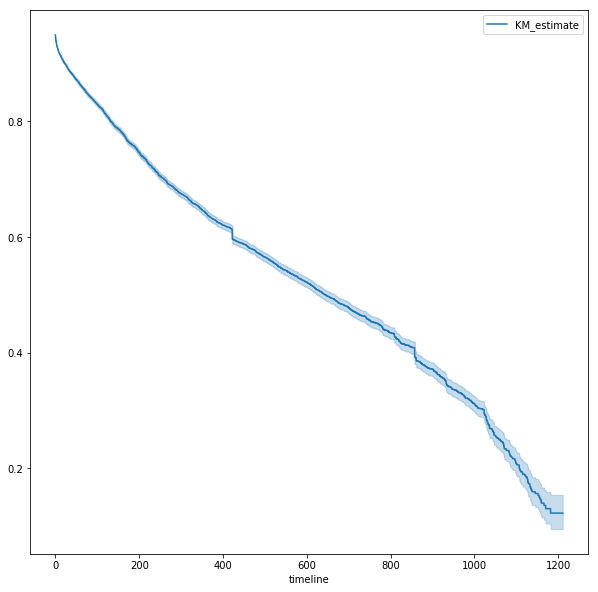

In [83]:
kmf.survival_function_
kmf.median_
kmf.plot()

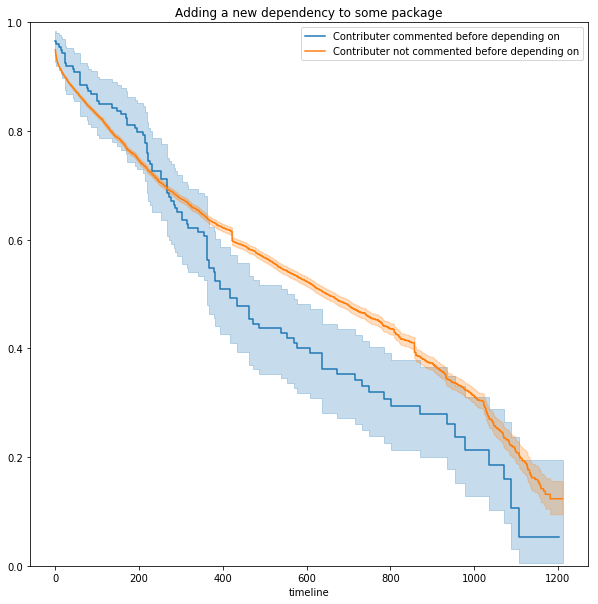

In [87]:
ax = plt.subplot(111)

cmnt = (df_data[lambda x: x["cntrcmnted"] == 1])
ncmnt = (df_data[lambda x: x["cntrcmnted"] == 0])
kmf.fit(cmnt['period'], event_observed=cmnt['time_to_come'], label="Contributer commented before depending on")
kmf.plot(ax=ax)
kmf.fit(ncmnt['period'], event_observed=ncmnt['time_to_come'], label="Contributer not commented before depending on")
kmf.plot(ax=ax)

plt.ylim(0, 1);
plt.title("Adding a new dependency to some package");